## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import tqdm
import json
import time
import sys

# Add the 'src' folder to the Python path
src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(src_dir)
# append the path of the directory containing the module you want to import
sys.path.append('master_thesis_dtu/src')

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../../')
from tqdm import tqdm
import numpy as np

from PIL import Image
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet_windows
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch
import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

from src.models.utils import *

#DERT model
from transformers import DetrForObjectDetection


Load model state


In [2]:
from transformers import DetrConfig, DetrForObjectDetection

config = DetrConfig.from_pretrained('facebook/detr-resnet-50',revision="no_timm",num_labels=2,id2label={0:"text",1:"fracture"},
                                                             ignore_mismatched_sizes=True) 
                                                             
detr_model = DetrForObjectDetection(config)
best_model = torch.load(f'../../models/Best_val_DETR_Model.pt',map_location=torch.device('cpu'))
detr_model.load_state_dict(best_model['model_state_dict'])
print(best_model['best_loss'])

0.8352892026176622


Load dataset

In [3]:
import sys
sys.path.append('../')
%cd ..
%cd ..
from src.data.my_rpg_dataset import CocoDetection
from src.data.my_rpg_dataset import collate_fn_COCO
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
test_dataset_detr = CocoDetection(path_folder="data", processor=processor,status='test')
test_dataloader_detr = DataLoader(test_dataset_detr, collate_fn=collate_fn_COCO, batch_size=1, shuffle=False,num_workers=0)

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\src
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [4]:
evaluator = CocoEvaluator(coco_gt=test_dataset_detr.coco, iou_types=["bbox"])

In [5]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


#### Visualization

In [6]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores_cnn, labels_cnn, boxes_cnn,scores_detr, labels_detr, boxes_detr,annotations,detr_model,image_id,confidence=0.5):
    fig = plt.figure(figsize=(15,10))

    fig.add_subplot(1, 3, 1)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={0:"text",1:"fracture"}

    for annotation in annotations:
        for label, box,c  in zip(torch.tensor([annotation['category_id']]).tolist(), torch.tensor([annotation['bbox']]).tolist(), colors):
            x,y,w,h = tuple(box)
            ax.add_patch(plt.Rectangle((x,y),w,h,
                                    fill=False, color=c, linewidth=3))
            text = f'{detr_model.config.id2label[label]}'
            ax.text(x, y, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("Target Image and Boxes")
    ########################################################################################################
    fig.add_subplot(1, 3, 2)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={0:"text",1:"fracture"}
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores_detr.tolist(), labels_detr.tolist(), boxes_detr.tolist(), colors):
        if score >= confidence:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            text = f'{detr_model.config.id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title(f"DETR Model prediction {image_id}")

    ########################################################################################################
    fig.add_subplot(1, 3, 3)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={2:"text",1:"fracture"}
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores_cnn.tolist(), labels_cnn.tolist(), boxes_cnn.tolist(), colors):
        if score >= confidence:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("CNN Model prediction")


    plt.show()

take detr predictions

In [10]:
# Set the model to evaluation mode
detr_model.eval()
results_detr = []

# Iterate over all batches in the test loader
for idx, batch in enumerate(tqdm(test_dataloader_detr)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    target = labels[0]

    # forward pass
    with torch.no_grad():
      outputs = detr_model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    %cd notebooks
    # load image based on ID
    image_id = target['image_id'].item()
    image = test_dataset_detr.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join(image['file_name']))
    target_annotations = test_dataset_detr.coco.imgToAnns[image_id]
    %cd ..


    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.5)
    results = postprocessed_outputs[0]
    # Append the results to the list
    results_detr.append((image, results['scores'], results['labels'], results['boxes'], target_annotations, image_id))
    #plot_results(image, results['scores'], results['labels'], results['boxes'],target_annotations,detr_model,confidence=0.5)
    if idx == 10 : break

  0%|          | 0/3022 [00:00<?, ?it/s]c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
  0%|          | 1/3022 [00:03<2:56:03,  3.50s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 2/3022 [00:07<3:24:45,  4.07s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 3/3022 [00:11<3:16:12,  3.90s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 4/3022 [00:15<3:19:26,  3.97s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 5/3022 [00:20<3:27:40,  4.13s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 6/3022 [00:24<3:31:39,  4.21s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 7/3022 [00:28<3:28:12,  4.14s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 8/3022 [00:33<3:35:55,  4.30s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 9/3022 [00:37<3:36:33,  4.31s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 10/3022 [00:41<3:28:34,  4.15s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 10/3022 [00:44<3:44:43,  4.48s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


take cnn perds


In [11]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


In [12]:
%cd notebooks

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [13]:
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles_new'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [14]:
#load the model state

model = get_model_instance_segmentation(3)
best_model = torch.load(f'../models/CNN_batch_32.pt',map_location=torch.device('cpu'))
model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [15]:
# Set the model to evaluation mode
model.eval()

results_cnn = []

# Iterate over all batches in the test loader
for batch_idx, (images, targets) in enumerate(tqdm(test_dataloader)):

    # Get the predictions for the batch of images
    predictions = model(images)

    # Iterate over all images in the batch
    for idx in range(len(images)):
        
        # Get the image, predicted scores, labels and boxes for the current image
        img = images[idx].cpu().permute(1, 2, 0)
        scores = predictions[idx]['scores']
        labels = predictions[idx]['labels']
        boxes = predictions[idx]['boxes']

        # Get the ground truth labels and boxes for the current image
        gt_labels = targets[idx]['labels']
        gt_boxes = targets[idx]['boxes']

        # Append the results for the current image to the list
        results_cnn.append((scores, labels, boxes))
    if batch_idx == 10 : break

  0%|          | 10/3022 [00:56<4:43:10,  5.64s/it]


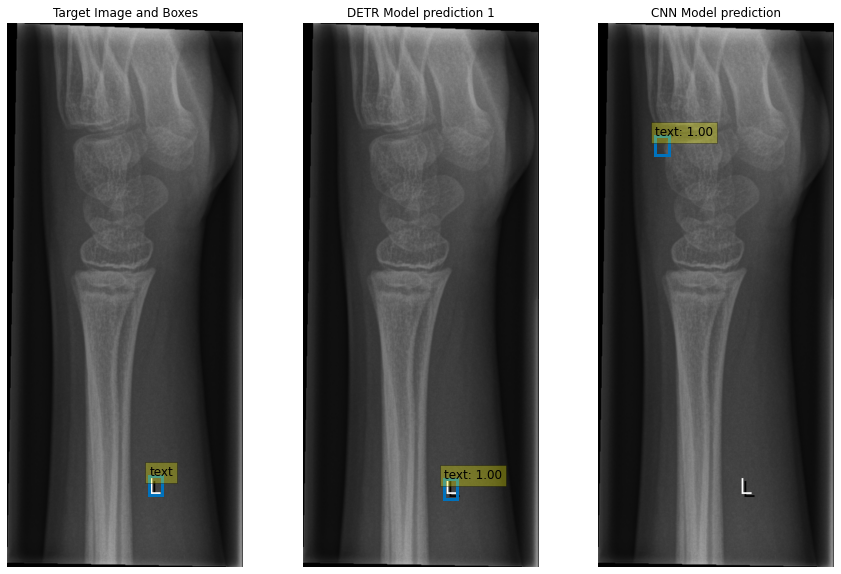

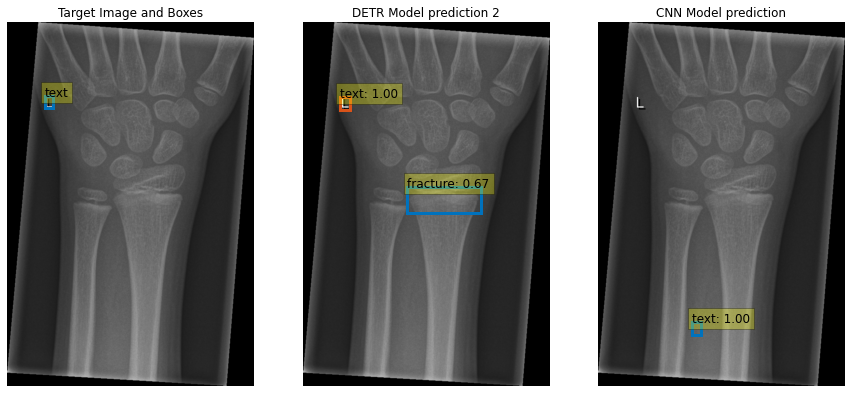

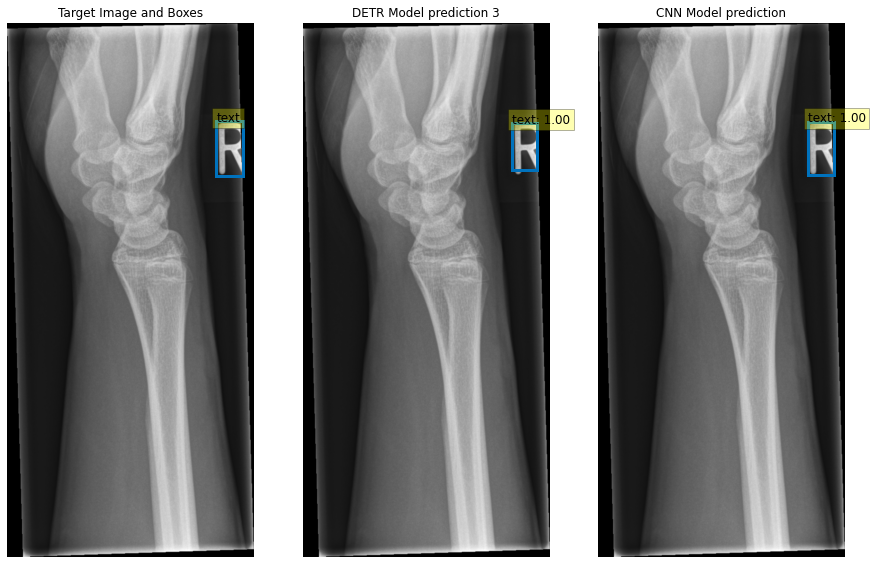

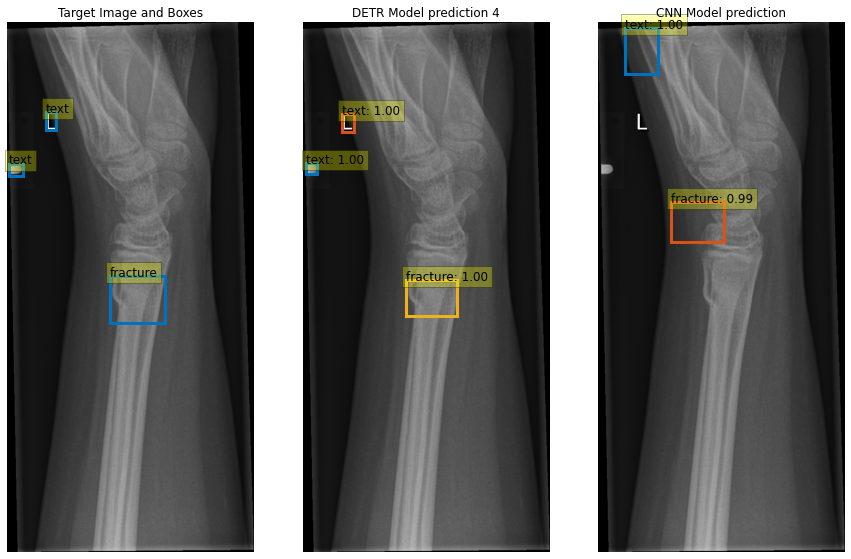

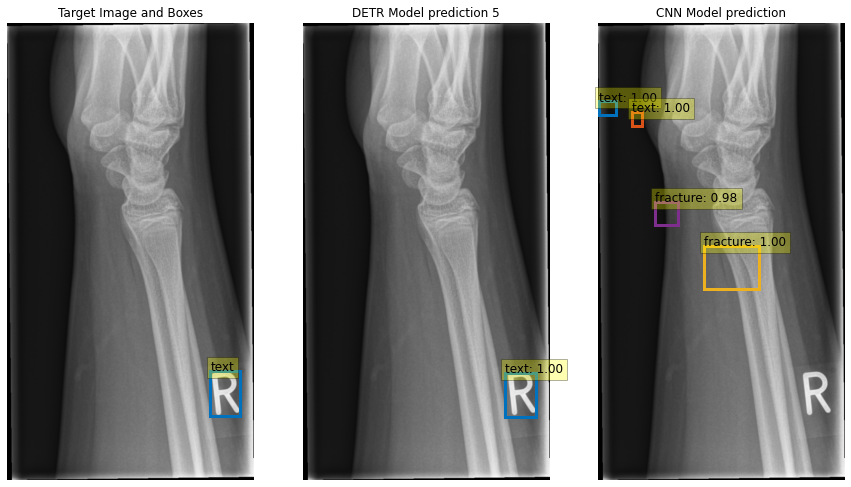

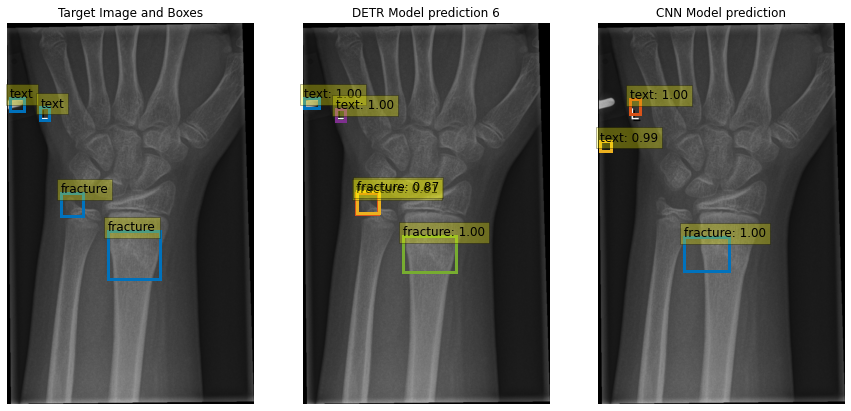

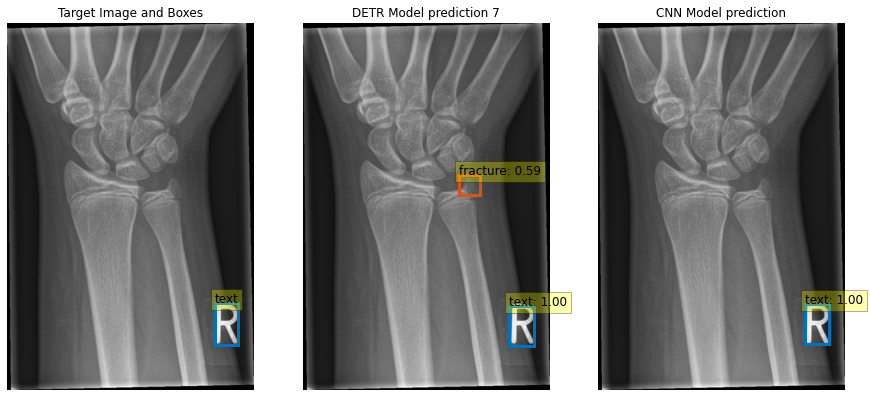

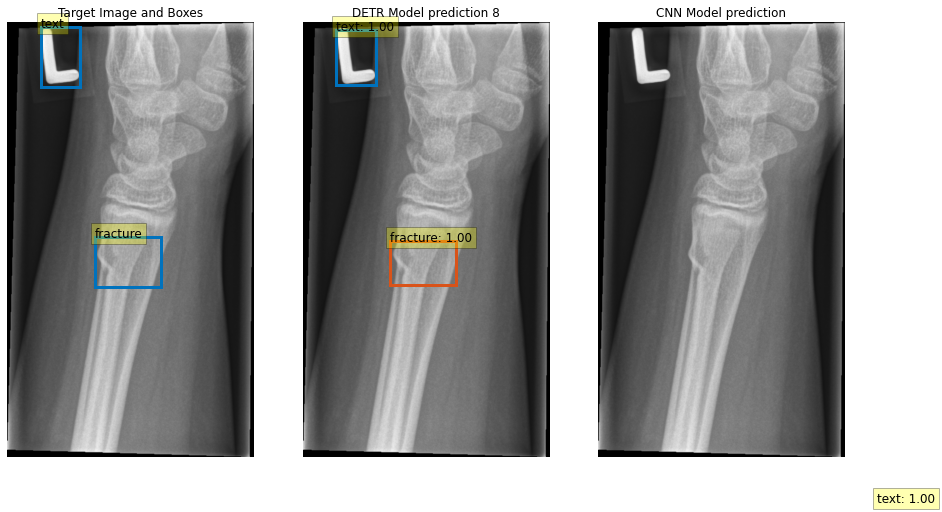

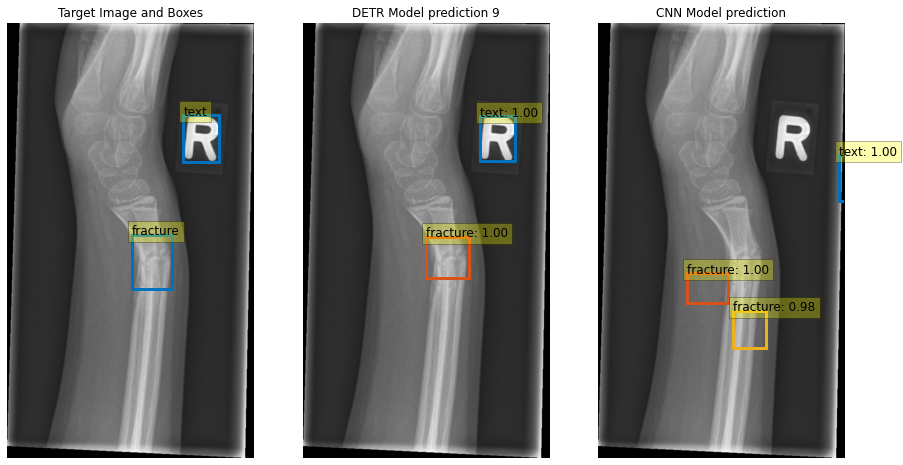

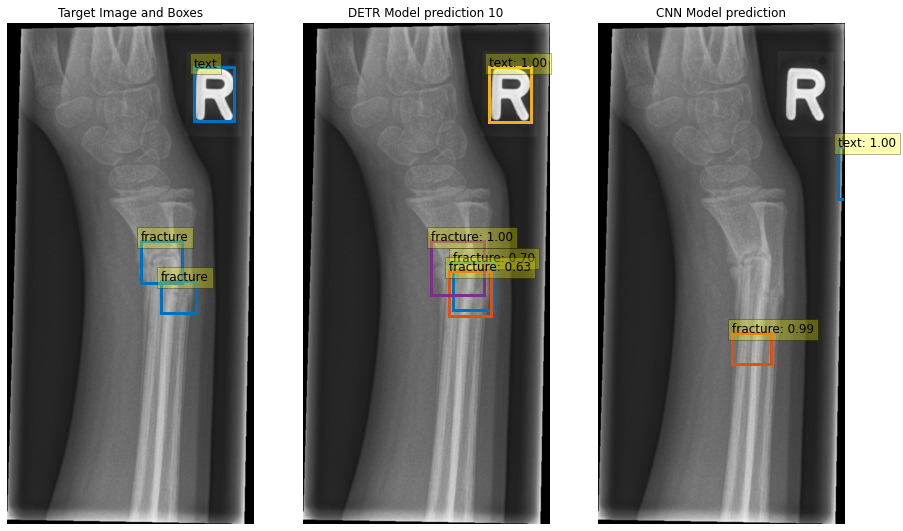

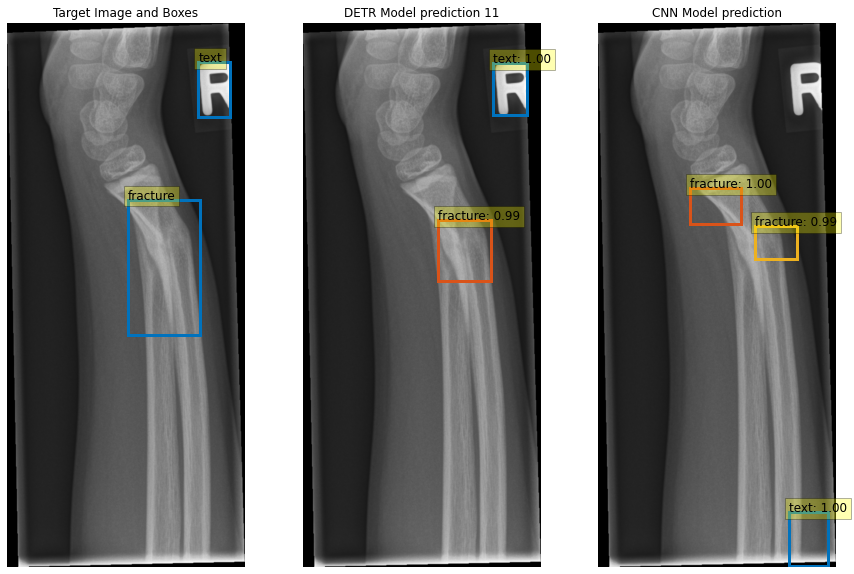

In [16]:
for cnn, detr in zip(results_cnn,results_detr):
    # Get the image and results for the current iteration
    scores_cnn, labels_cnn, boxes_cnn = cnn

    pil_img , scores_detr , labels_detr , boxes_detr , annotations,image_id = detr
    
    
    # Call your plotting function for the current image and save the plot with the specified name
    plot_results(pil_img, scores_cnn, labels_cnn, boxes_cnn,scores_detr, labels_detr, boxes_detr,annotations,detr_model,image_id,confidence=0.5)